In [96]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [74]:
train = pd.read_csv('train.tsv', index_col=0, sep="\t") # 学習用データ
test = pd.read_csv('test.tsv', index_col=0, sep="\t") # 学習用データ
submit = pd.read_csv('sample_submit.tsv' , header=None, sep="\t") # 応募用サンプルファイル

In [75]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
7,0,3,male,2.0,3,1,21.0750,S
9,1,2,female,14.0,1,0,30.0708,C
11,1,1,female,58.0,0,0,26.5500,S
...,...,...,...,...,...,...,...,...
873,0,3,male,47.0,0,0,9.0000,S
874,1,2,female,28.0,1,0,24.0000,C
879,1,1,female,56.0,0,1,83.1583,C


In [76]:
train.dtypes

survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [77]:
test

,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
...,...,...,...,...,...,...,...
885,3,female,39.0,0,5,29.1250,Q
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S


In [78]:
submit

,0,1
0,0,0
1,1,1
2,2,0
3,5,1
4,6,1
...,...,...
441,885,1
442,886,1
443,887,1
444,889,1


In [79]:

le = LabelEncoder()
le.fit(train['sex'])
train['sex'] = le.transform(train['sex']).astype("int")

le.fit(train['embarked'])
train['embarked'] = le.transform(train['embarked']).astype("int")

le.fit(test['sex'])
test['sex'] = le.transform(test['sex']).astype("int")

le.fit(test['embarked'])
test['embarked'] = le.transform(test['embarked']).astype("int")

train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
7,0,3,1,2.0,3,1,21.0750,2
9,1,2,0,14.0,1,0,30.0708,0
11,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.0,0,0,9.0000,2
874,1,2,0,28.0,1,0,24.0000,0
879,1,1,0,56.0,0,1,83.1583,0


In [80]:
train.dtypes

survived      int64
pclass        int64
sex           int32
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int32
dtype: object

In [81]:
print(train.corr())

          survived    pclass       sex       age     sibsp     parch   
survived  1.000000 -0.358097 -0.559465 -0.081394 -0.045087  0.079669  \
pclass   -0.358097  1.000000  0.193761 -0.300686  0.069857 -0.015726   
sex      -0.559465  0.193761  1.000000  0.072899 -0.097883 -0.220046   
age      -0.081394 -0.300686  0.072899  1.000000 -0.283126 -0.153382   
sibsp    -0.045087  0.069857 -0.097883 -0.283126  1.000000  0.423522   
parch     0.079669 -0.015726 -0.220046 -0.153382  0.423522  1.000000   
fare      0.258605 -0.549651 -0.168935  0.098488  0.164773  0.241855   
embarked -0.173428  0.103049  0.112383  0.010552  0.104772  0.058022   

              fare  embarked  
survived  0.258605 -0.173428  
pclass   -0.549651  0.103049  
sex      -0.168935  0.112383  
age       0.098488  0.010552  
sibsp     0.164773  0.104772  
parch     0.241855  0.058022  
fare      1.000000 -0.157135  
embarked -0.157135  1.000000  


In [82]:
train = train.reset_index(drop=True)
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,0,35.0,1,0,53.1000,2
1,0,3,1,35.0,0,0,8.0500,2
2,0,3,1,2.0,3,1,21.0750,2
3,1,2,0,14.0,1,0,30.0708,0
4,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
440,0,3,1,47.0,0,0,9.0000,2
441,1,2,0,28.0,1,0,24.0000,0
442,1,1,0,56.0,0,1,83.1583,0
443,0,3,1,25.0,0,0,7.0500,2


In [83]:
SPLIT  = 5
train["split"] = 0

kf = StratifiedKFold(n_splits=SPLIT, random_state=2022, shuffle=True)
for i, (train_idx, val_idx) in enumerate(kf.split(train, train["survived"])):
    print(train_idx)
    print(val_idx)
    train.loc[val_idx, "split"] = int(i)

[  1   2   3   4   5   6   7   8   9  10  11  12  15  16  17  20  21  22
  23  24  25  26  27  29  31  33  34  35  36  39  40  41  42  43  44  45
  47  48  49  50  53  54  56  57  58  60  61  62  63  65  66  67  68  69
  70  71  72  73  74  77  78  79  80  83  84  85  86  87  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 125 127 128 129 131 132
 133 134 137 138 140 141 142 143 144 145 146 147 148 149 150 153 154 156
 159 161 162 163 164 165 166 167 168 170 171 172 174 175 176 177 178 179
 180 181 182 183 184 185 187 189 190 191 192 193 194 198 199 200 202 203
 205 207 208 209 210 211 212 213 214 215 217 218 219 221 222 223 224 227
 228 230 232 233 235 236 237 238 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 255 257 259 261 262 263 264 265 268 269 271 272 273 274
 275 276 277 279 280 281 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 30

In [84]:
def cal_roc(y_true, y_pred):
  return roc_auc_score(y_true, y_pred)

In [93]:
lgb_fit_params ={'num_boost_rounds': 10000,
                 'early_stopping_rounds': 50,
                 'verbose_eval': 10,
                }


lgb_model_params = {'boosting_type': 'gbdt',
                    'device': 'gpu', 
                    'metric': 'auc',
                    'learning_rate': 0.05,
                    'max_depth': -1,
                    'num_leaves': 72,
                    'min_data_in_leaf': 20,
                    'max_bin': 255,
                    'verbose': -1,
                    'n_jobs': -1,
                    'feature_pre_filter': False,
                    'bagging_fraction': 0.9918357136100413,
                    'bagging_freq': 4,
                    'feature_fraction': 0.9840000000000001,
                    'lambda_l1': 7.386178645626934,
                    'lambda_l2': 4.572888900518312e-08,
                    'min_child_samples': 20}

In [94]:
train_df = train[train["split"]!=1]
val_df = train[train["split"]==1]

X_train, y_train = train_df.drop(columns=["survived", "split"]), train_df["survived"].values
X_val, y_val = val_df.drop(columns=["survived", "split"]), val_df["survived"].values
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)

model = lgb.train(lgb_model_params,
                    train_set=lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=lgb_fit_params['verbose_eval'],
                    num_boost_round=lgb_fit_params['num_boost_rounds'],
                    callbacks=[lgb.early_stopping(lgb_fit_params['early_stopping_rounds'])],
                    )

val_pred = model.predict(X_val)
score = cal_roc(y_val, val_pred)
print(f"ROC: {score}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.864753	valid_1's auc: 0.814465
[20]	training's auc: 0.868331	valid_1's auc: 0.812893
[30]	training's auc: 0.87081	valid_1's auc: 0.817086
[40]	training's auc: 0.870728	valid_1's auc: 0.819444
[50]	training's auc: 0.870695	valid_1's auc: 0.81892
[60]	training's auc: 0.871089	valid_1's auc: 0.822065
[70]	training's auc: 0.87081	valid_1's auc: 0.821279
[80]	training's auc: 0.870744	valid_1's auc: 0.821279
[90]	training's auc: 0.870744	valid_1's auc: 0.821279
[100]	training's auc: 0.870449	valid_1's auc: 0.821279
Early stopping, best iteration is:
[52]	training's auc: 0.871089	valid_1's auc: 0.822065
ROC: 0.8220649895178198


c:\Users\daich\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


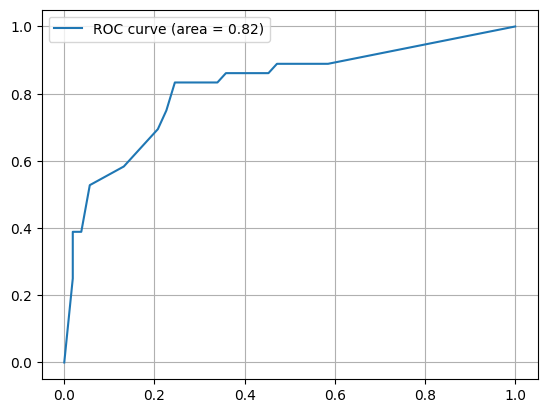

In [98]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.grid()
plt.show()

    feature  importance
0    pclass    8.723171
1       sex  227.989829
2       age   11.734493
3     sibsp    1.689234
4     parch    0.347495
5      fare    0.493400
6  embarked    5.734665


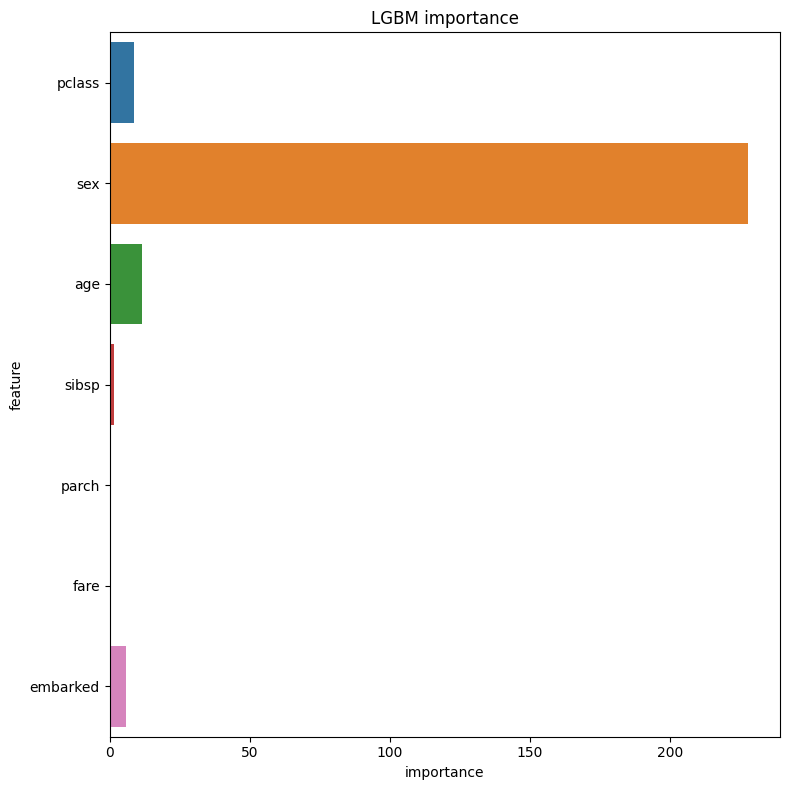

In [87]:
tmp = pd.DataFrame()
tmp['feature'] = model.feature_name()
tmp['importance'] = model.feature_importance(importance_type='gain')
print(tmp)

plt.figure(figsize=(8, 8))
sns.barplot(x='importance', y='feature', data=tmp)
plt.title('LGBM importance')
plt.rcParams["font.size"] = 10

plt.tight_layout()

plt.show()

In [88]:
score_each_model = []

pred = model.predict(test)
pred

array([0.19094505, 0.78545659, 0.57925599, 0.15999686, 0.37145924,
       0.54009893, 0.59975706, 0.15999686, 0.57925599, 0.78545659,
       0.15999686, 0.59975706, 0.15999686, 0.15999686, 0.57925599,
       0.37412825, 0.39585788, 0.78545659, 0.40168539, 0.37412825,
       0.15999686, 0.59975706, 0.57925599, 0.57925599, 0.15999686,
       0.19094505, 0.33056952, 0.59975706, 0.35278318, 0.15999686,
       0.78545659, 0.39901639, 0.36830073, 0.29962132, 0.37412825,
       0.39585788, 0.33056952, 0.73090482, 0.54009893, 0.5606    ,
       0.19143455, 0.15999686, 0.15999686, 0.15999686, 0.35011417,
       0.57925599, 0.15999686, 0.59975706, 0.15999686, 0.15999686,
       0.37412825, 0.39585788, 0.39901639, 0.57925599, 0.15999686,
       0.37145924, 0.15999686, 0.19094505, 0.15999686, 0.15999686,
       0.15999686, 0.59975706, 0.57925599, 0.15999686, 0.39901639,
       0.33056952, 0.37145924, 0.15999686, 0.57925599, 0.78545659,
       0.5606    , 0.57925599, 0.59975706, 0.15999686, 0.19094

In [89]:
submit.iloc[:, 1] = pred
submit

,0,1
0,0,0.190945
1,1,0.785457
2,2,0.579256
3,5,0.159997
4,6,0.371459
...,...,...
441,885,0.560600
442,886,0.159997
443,887,0.785457
444,889,0.395858


In [90]:
submit.to_csv('submit.tsv',header=None)